# Initializing particles in LAMTA

Tutorial to initialize particles for advection.

The `Diagnostics.ParticleSet` class creates an object containing:

- the velocity field
- the initial particle positions
- the mode and advection method options

`Diagnostics.ParticleSet` is a child class of `Lagrangian`.  
It therefore inherits all methods and properties from the
`Lagrangian` class (see `Lagrangian.ipynb`).

---

## Particle initialisation methods

Particles can be initialised using three different class methods:

### `from_input`
Particles are initialised by directly providing `(x, y, t)`
positions and times for individual particles.

### `from_grid`
Particles are seeded on a regular grid defined by:

- `(x, y)` spatial limits
- `delta0` (horizontal grid step)

Particles are initialised for each time between `dayv`
(date `'YYYY-mm-dd'`) and `dayv ± numdays`.

### `from_disk`
Particles are initialised inside a disk defined by:

- a centre `(pxc, pyc)`
- a radius (in degrees of longitude/latitude)

Particles can be sampled:

- along concentric circles from the centre to the maximum radius  
  (`sample='circle'`)
- randomly inside the disk  
  (`sample='random'`)

---

Three examples are provided for each class method.


Import librairies

In [1]:
from lamta.Diagnostics import ParticleSet, Lagrangian
from lamta.Load_nc import loadCMEMSuv
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

Load Ocean field

In [2]:
from pathlib import Path

from lamta_examples.data_fetch import ensure_dataset
from lamta.Load_nc import loadCMEMSuv

DATA_DIR = Path(
    ensure_dataset("altimetry_nrt_global_20220909-20220929.tar.gz")
)

rep = str(DATA_DIR / "altimetry" / "nrt_global") + "/"

all_days = ['20220919','20220920','20220921','20220922','20220923','20220924','20220925','20220926','20220927','20220928','20220929']
varn = {'longitude':'longitude','latitude':'latitude','u':'ugos','v':'vgos'}
field = loadCMEMSuv(all_days,rep,varn,unit='deg/d')

In [3]:
########## 1) Individual positions: from_input
# (x,y) positions
px = np.array([6,6,6])
py = np.array([41,41.5,42])
# time (days)
dayv = '2022-09-19'
numdays = 10
day1 = dt.datetime.strptime(dayv,'%Y-%m-%d').date()
day1j = dt.datetime.toordinal(day1)
pt = np.array([day1j,day1j+numdays]) # forward time
numstep = 30

pset = ParticleSet.from_input(pt,px,py,fieldset=field) #forward

#compute trajectories
trjf = pset.rk4flat(Lagrangian.interpf,numstep,coordinates='spherical')

c:\Users\lloyd\miniforge3\envs\lamta_examples\Lib\site-packages\shapely\creation.py:218: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, np.intc(handle_nan), out=out, **kwargs)
c:\Users\lloyd\miniforge3\envs\lamta_examples\Lib\site-packages\shapely\creation.py:218: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, np.intc(handle_nan), out=out, **kwargs)
c:\Users\lloyd\miniforge3\envs\lamta_examples\Lib\site-packages\shapely\creation.py:218: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, np.intc(handle_nan), out=out, **kwargs)


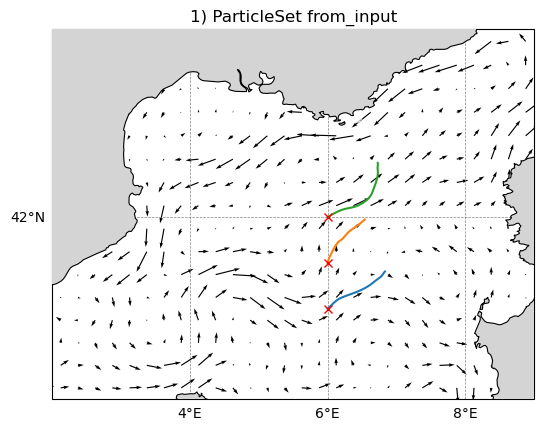

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.ticker import MultipleLocator

lat = np.asarray(field["lat"])
lon = np.asarray(field["lon"])
Y, X = np.meshgrid(lat, lon)   # shapes: (nlon, nlat)  EXACTLY like your Basemap line

u0 = np.asarray(field["u"][0, :, :])
v0 = np.asarray(field["v"][0, :, :])

if u0.shape != X.shape:
    if u0.T.shape == X.shape:
        u0 = u0.T
        v0 = v0.T
    else:
        raise ValueError(f"Cannot align u/v with grid: X/Y={X.shape}, u0={u0.shape}")

fig = plt.figure()
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent([2, 9, 40, 44], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor="0.83", edgecolor="none", zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=101)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, linestyle="--", color="0.5")
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = MultipleLocator(2)
gl.ylocator = MultipleLocator(2)

skip = 1
ax.quiver(
    X[::skip, ::skip], Y[::skip, ::skip],
    u0[::skip, ::skip], v0[::skip, ::skip],
    transform=ccrs.PlateCarree(),
    scale=5,
    color="k",
    zorder=1,
)

trjx = np.asarray(trjf["trjx"])
trjy = np.asarray(trjf["trjy"])

ntime = len(trjf["trjx"]) if isinstance(trjf["trjx"], (list, tuple)) else None
if trjx.ndim == 2 and ntime is not None:
    if trjx.shape[0] != ntime and trjx.shape[1] == ntime:
        trjx = trjx.T
        trjy = trjy.T

good = np.isfinite(trjx) & np.isfinite(trjy)
trjx = np.where(good, trjx, np.nan)
trjy = np.where(good, trjy, np.nan)

ax.plot(trjx, trjy, transform=ccrs.PlateCarree(), zorder=102)
ax.plot(trjx[0, :], trjy[0, :], "rx", transform=ccrs.PlateCarree(), zorder=103)

plt.title("1) ParticleSet from_input")
plt.show()


In [5]:
########## 2) Positions on regular grid: from_grid
# (x,y) positions
loni = [5.5,7] # x limits 
lati = [41.5,42.5] # y limits
delta0 = 0.3 # horizontal step in degree
# time
dayv = '2022-09-19'
numdays = 10
numstep = 4
psetg = ParticleSet.from_grid(numdays,loni,lati,delta0,dayv,fieldset=field,mode='forward')

#compute trajectories
trjfg = psetg.rk4flat(Lagrangian.interpf,numstep,coordinates='spherical')

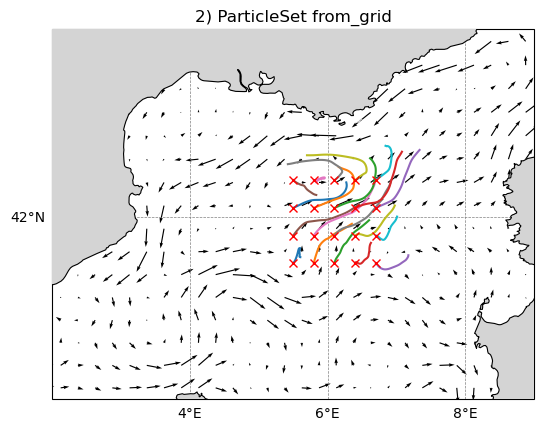

In [7]:
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.ticker import MultipleLocator

fig = plt.figure()
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent([2, 9, 40, 44], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor="0.83", edgecolor="none", zorder=100)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=101)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, linestyle="--", color="0.5")
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = MultipleLocator(2)
gl.ylocator = MultipleLocator(2)

skip = 1  # set >1 if you want fewer arrows
ax.quiver(
    X[::skip, ::skip], Y[::skip, ::skip],
    u0[::skip, ::skip], v0[::skip, ::skip],
    transform=ccrs.PlateCarree(),
    scale=5,
    color="k",
    zorder=1,
)

# --- Trajectories from_grid (trjfg) ---
trjx = np.asarray(trjfg["trjx"])
trjy = np.asarray(trjfg["trjy"])

# Force (ntime, ntraj) to avoid “fan”
ntime = len(trjfg["trjx"]) if isinstance(trjfg["trjx"], (list, tuple)) else None
if trjx.ndim == 2 and ntime is not None:
    if trjx.shape[0] != ntime and trjx.shape[1] == ntime:
        trjx = trjx.T
        trjy = trjy.T

# Break lines at NaNs
good = np.isfinite(trjx) & np.isfinite(trjy)
trjx = np.where(good, trjx, np.nan)
trjy = np.where(good, trjy, np.nan)

ax.plot(trjx, trjy, transform=ccrs.PlateCarree(), zorder=102)
ax.plot(trjx[0, :], trjy[0, :], "rx", transform=ccrs.PlateCarree(), zorder=103)

plt.title("2) ParticleSet from_grid")
plt.show()


In [8]:
########## 3) Positions on disk: from_disk
# (x,y) positions
lonc = 6 # x center 
latc = 41.5 # y center
rad = 0.5 # radius in degree
# time
dayv = '2022-09-19'
numdays = 10
numstep = 10

## sampling along circles
# Argument "deltar" defines the number of circles along which particles are set.
# If not defined default value is 10.
# Argument "npoints" defines the number of particle on each circle (default is 100).
psetdc = ParticleSet.from_disk(numdays,lonc,latc,rad,dayv,
                              sample='circles',fieldset=field,mode='forward',
                               deltar=2, npoints=5)
#compute trajectories
trjfdc = psetdc.rk4flat(Lagrangian.interpf,numstep,coordinates='spherical')

## random sampling
# Argument "npoints" defines the number of particles inside the disk. 
# If not defined default value is 1000. 
# For illustration purposes here we only set 10 particles
psetdr = ParticleSet.from_disk(numdays,lonc,latc,rad,dayv,
                              sample='random',fieldset=field,mode='forward',npoints=10)
#compute trajectories
trjfdr = psetdr.rk4flat(Lagrangian.interpf,numstep,coordinates='spherical')

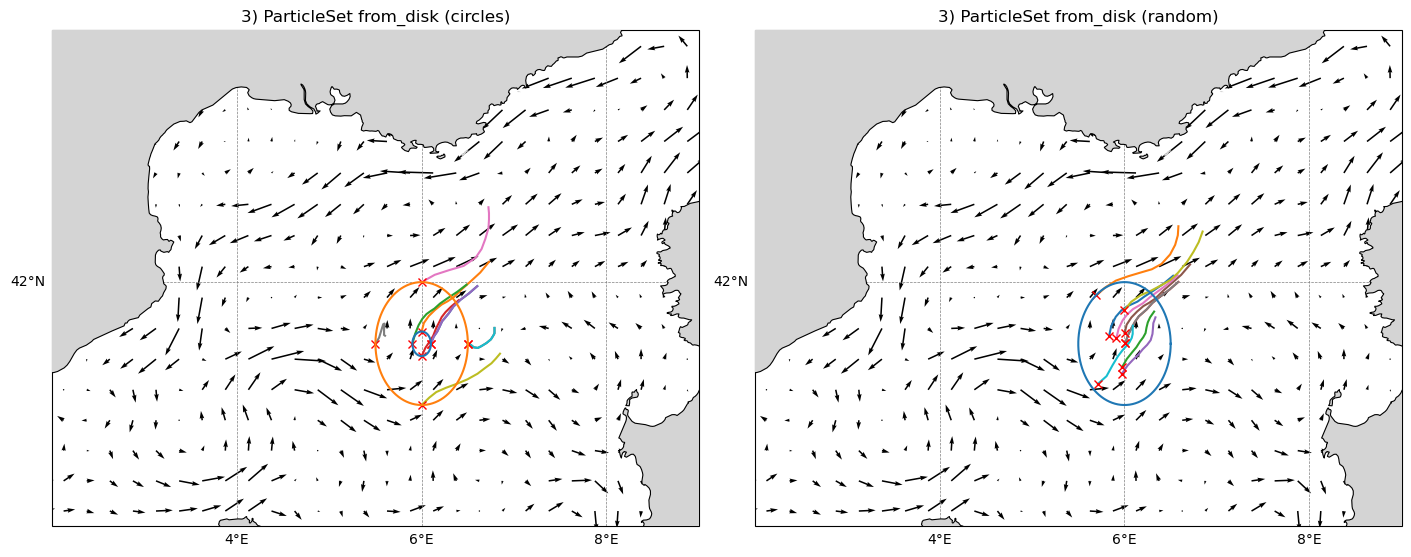

In [9]:
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.ticker import MultipleLocator

extent = [2, 9, 40, 44]
proj = ccrs.Mercator()

fig, axes = plt.subplots(
    1, 2,
    figsize=(14, 6),
    subplot_kw=dict(projection=proj),
    constrained_layout=True,
)

titles = [
    "3) ParticleSet from_disk (circles)",
    "3) ParticleSet from_disk (random)",
]

traj_sets = [
    trjfdc,  # circles
    trjfdr,  # random
]

for ax, trjf_loc, title in zip(axes, traj_sets, titles):

    ax.set_extent(extent, crs=ccrs.PlateCarree())

    ax.add_feature(cfeature.LAND, facecolor="0.83", edgecolor="none", zorder=100)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=101)

    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5,
        linestyle="--",
        color="0.5",
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = MultipleLocator(2)
    gl.ylocator = MultipleLocator(2)

    ax.quiver(
        X, Y, u0, v0,
        transform=ccrs.PlateCarree(),
        scale=5,
        color="k",
        zorder=1,
    )

    # --- Trajectories (NO reshaping, NO looping) ---
    trjx = np.asarray(trjf_loc["trjx"])
    trjy = np.asarray(trjf_loc["trjy"])

    ax.plot(
        trjx, trjy,
        transform=ccrs.PlateCarree(),
        zorder=102,
    )

    # Initial positions (red X)
    ax.plot(
        trjx[0], trjy[0],
        "rx",
        transform=ccrs.PlateCarree(),
        zorder=103,
    )

    # --- Circles ---
    a = np.linspace(0, 2 * np.pi, 100)

    # inner circle (only for "circles" case)
    if title.endswith("(circles)"):
        cx = lonc + np.cos(a) * 0.1
        cy = latc + np.sin(a) * 0.1
        ax.plot(cx, cy, "-", transform=ccrs.PlateCarree(), zorder=104)

    # outer circle (both cases)
    cx = lonc + np.cos(a) * rad
    cy = latc + np.sin(a) * rad
    ax.plot(cx, cy, "-", transform=ccrs.PlateCarree(), zorder=104)

    ax.set_title(title)

plt.show()
